In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
#list of all disorders from the ldsc analysis
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ARTHRITIS','ASD','AUD','BILIARYCHIRROSIS','BPD','CHRONICPAIN','CUD','ENDOMETRIOSIS','EPILEPSY','FATIGUE','FIBROMYALGIA','GDM','GOUT','HOARDING','IBD','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PCOS','PREECLAMPSIA','PRETERMBIRTH','PTSD','SJOGRENS','SZC','THYROID','TS']

In [3]:
len(disorders)

36

In [4]:
#make list of files to read in
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [ ]:
len(ex_table_files)

In [5]:

df_list = []

#read in files to dataframes 
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    #select relevant columns
    df = df[['p1','p2','rg','se','z','p']]
    #remove last two rows
    df = df.iloc[:-2]
    df_list.append(df)

In [ ]:
len(df_list)

In [6]:
def make_correlation_matrix2(column, df_list):
    n = len(df_list) +1
    array = np.zeros((n, n))

    for i, df in enumerate(df_list):
        val = df[column].values

        if len(val) > 0:  # Check if 'rg' column is not empty
            # Extract values of 'rg' column to a list
            rg_values = list(val)

            # Fill the matrix starting from below the diagonal
            for j in range(i + 1, n):
                array[j, i] = rg_values.pop(0)

    # Fill the diagonal 
    if column == 'rg':            
        np.fill_diagonal(array, 1)
    else:
        np.fill_diagonal(array, 0.00005)

    # Convert the filled cells to numeric
    array = array.astype(float)
    

    # Create a DataFrame with disorders as column and index names
    return pd.DataFrame(array, index=disorders, columns=disorders), array


In [7]:
#corr_pval_df = make_correlation_matrix('p', df_list)
gen_corr_df, corr_matrix = make_correlation_matrix2('rg', df_list)

In [21]:
gen_corr_df.describe()

,ADHD,ANOREXIA,ANXIETY,ARTHRITIS,ASD,AUD,BILIARYCHIRROSIS,BPD,CHRONICPAIN,CUD,...,PANIC,PARKINSONS,PCOS,PREECLAMPSIA,PRETERMBIRTH,PTSD,SJOGRENS,SZC,THYROID,TS
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.00000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.218919,-0.022278,0.234251,0.078150,0.093744,0.098098,0.004475,0.103086,0.166666,0.11090,...,0.058806,0.065059,0.021565,0.003325,0.082594,0.037094,0.057372,0.030725,0.031222,0.027778
std,0.257560,0.219785,0.290243,0.240141,0.225656,0.222185,0.273365,0.220928,0.229004,0.25111,...,0.185582,0.195856,0.179969,0.209976,0.248198,0.180694,0.220467,0.167624,0.167356,0.166667
min,-0.141500,-0.446100,-0.370300,-0.373200,-0.334800,-0.116800,-1.135000,-0.144000,-0.114500,-0.13410,...,-0.093140,0.000000,-0.298000,-0.703900,0.000000,-0.170200,-0.081600,-0.023700,0.000000,0.000000
25%,0.073175,-0.125550,0.002155,-0.036150,0.000000,-0.009231,-0.013950,-0.000875,0.000000,-0.00105,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.157000,-0.034500,0.186950,0.005950,0.067050,0.028455,0.003400,0.020000,0.123750,0.00940,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.265750,0.033050,0.368100,0.101525,0.151300,0.127225,0.083050,0.127275,0.270350,0.12070,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
gen_corr_df.fillna(0, inplace=True)
gen_corr_df = gen_corr_df.clip(lower=-1.25, upper=1.25)

In [22]:
full_matrix = np.tril(corr_matrix) + np.tril(corr_matrix, -1).T
full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)

In [ ]:
""" full_df.to_csv('genetic_correlation.csv', header=True, index=True)
gen_corr_df.to_csv('genetic_correlation_all.csv', header= True, index=True) """

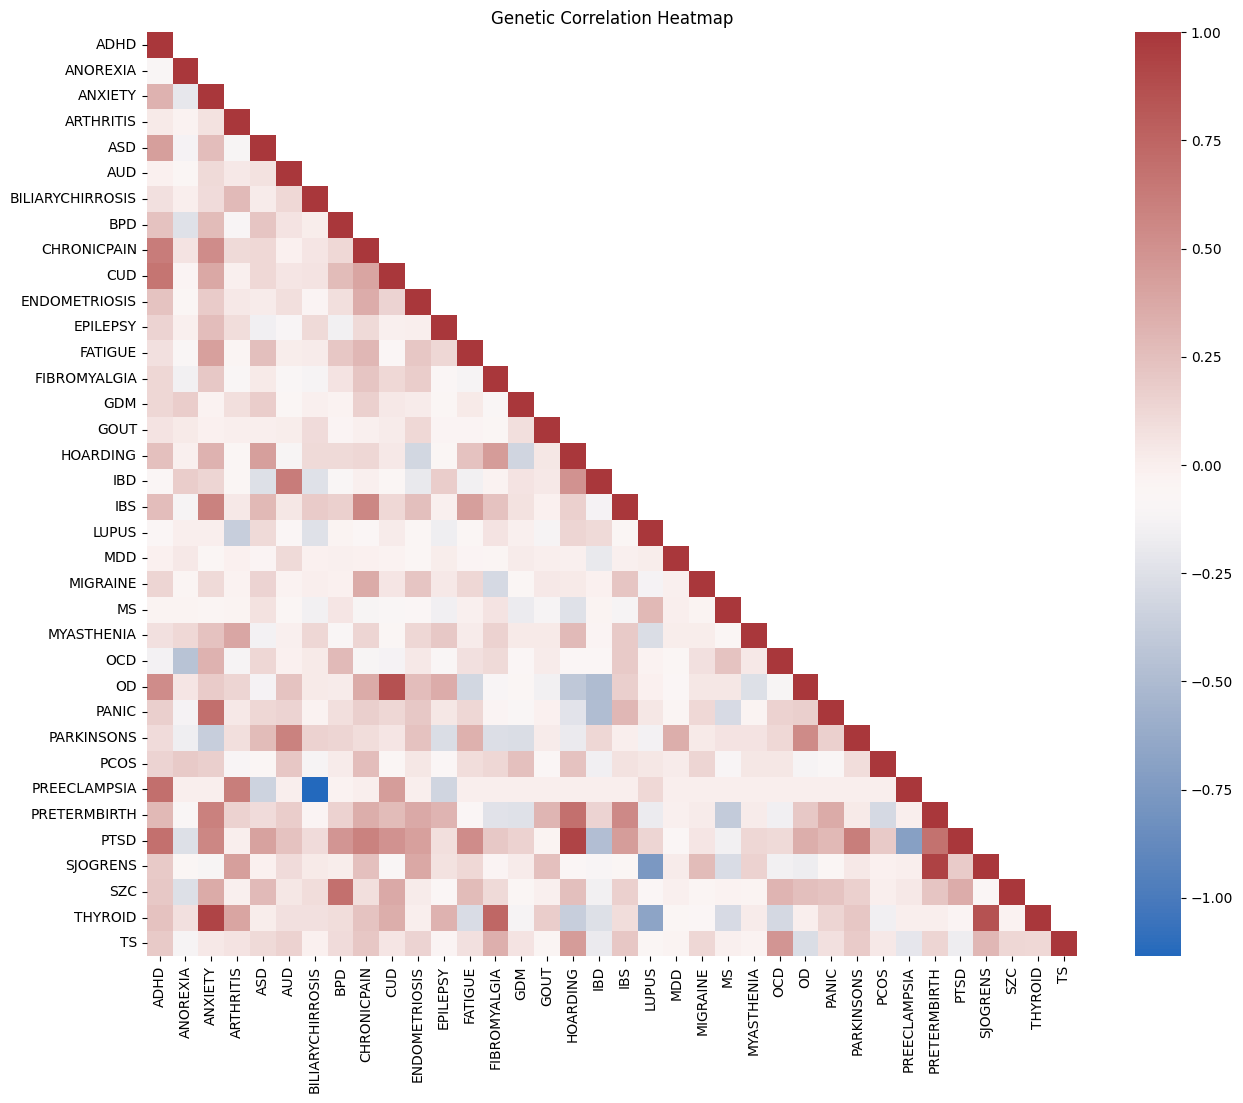

In [23]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
heatmap= sns.heatmap(gen_corr_df, cmap='vlag',mask=mask)

plt.title('Genetic Correlation Heatmap')
plt.show()



<Figure size 2000x2000 with 0 Axes>

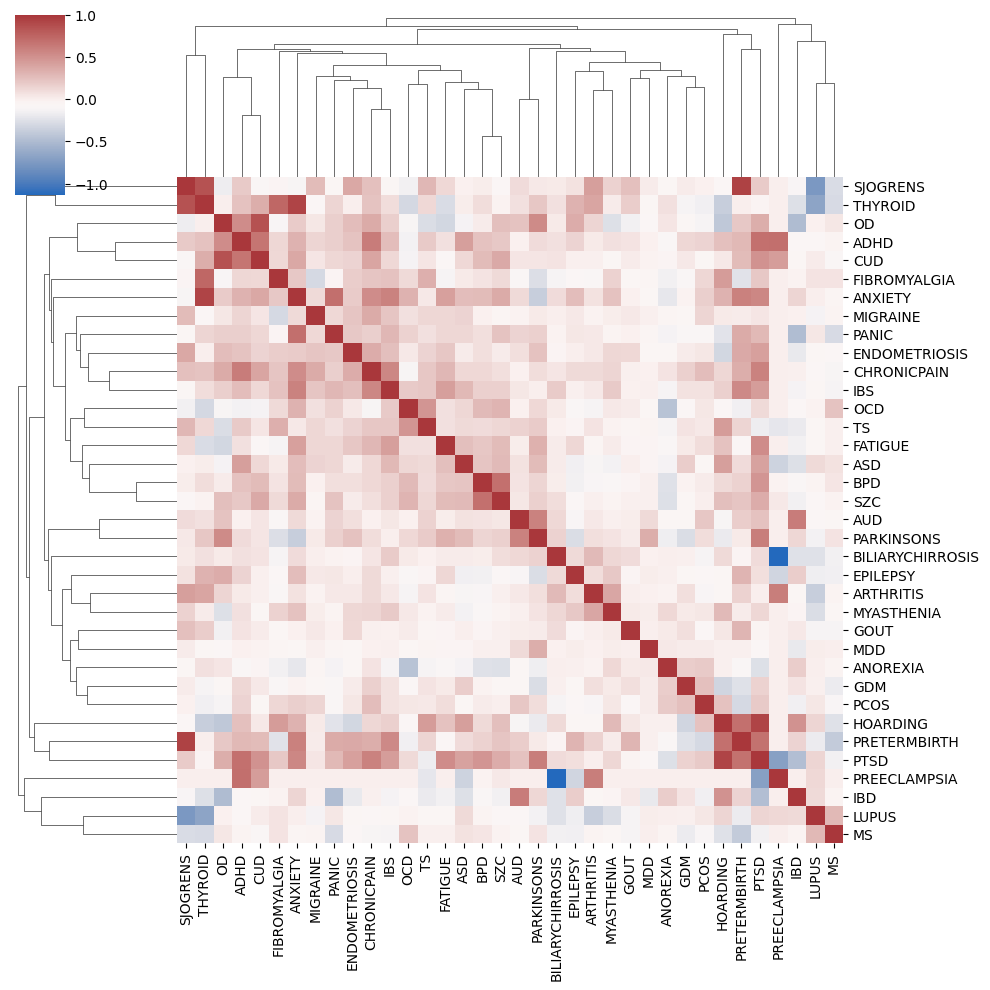

In [24]:
#plot clustermap
plt.figure(figsize=(20,20))
sns.clustermap(full_df,cmap='vlag')
plt.show()